## Import Library

In [1]:
import pandas as pd
import numpy as np
import os
import zipfile

from google.colab import files

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
!pip install -q kaggle

## Load Data

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vaniarachmawatidewi","key":"09e2f7f056fcf18caf821928c3a81be8"}'}

In [4]:
!mkdir book_recommendation
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arashnic/book-recommendation-dataset -p /content/book_recommendation/

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
  0% 0.00/24.3M [00:00<?, ?B/s]
100% 24.3M/24.3M [00:00<00:00, 561MB/s]


In [5]:
!unzip '/content/book_recommendation/book-recommendation-dataset.zip' -d /content/book_recommendation/

Archive:  /content/book_recommendation/book-recommendation-dataset.zip
  inflating: /content/book_recommendation/Books.csv  
  inflating: /content/book_recommendation/DeepRec.png  
  inflating: /content/book_recommendation/Ratings.csv  
  inflating: /content/book_recommendation/Users.csv  
  inflating: /content/book_recommendation/classicRec.png  
  inflating: /content/book_recommendation/recsys_taxonomy2.png  


In [6]:
books = pd.read_csv('/content/book_recommendation/Books.csv', low_memory=False)
users = pd.read_csv('/content/book_recommendation/Users.csv', low_memory=False)
ratings = pd.read_csv('/content/book_recommendation/Ratings.csv', low_memory=False)

## Data Understanding

In [7]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [8]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [9]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Insight


*   Dataset terdiri dari informasi buku pengguna dan rating.
*   Dataset `Ratings` merupakan yang terbesar, hal ini mencerminkan banyaknya interaksi pengguna dengan buku.

## Univariate Exploratory Data Analysis

Variabel pada dataset Book Recommendation yaitu sebagai berikut :

*   Books   :  menyediakan informasi detail tentang buku.
*   Users   :  memberikan informasi tentang pengguna yang memberikan rating.
*   Ratings :  berisi interaksi antara pengguna dan buku dalam bentuk rating. Dat ini menunjukkan preferensi pengguna terhadap buku-buku tertentu. Dataset ini merupakan yang terbesar, hal ini menunjukkan bahwa ada banyak interaksi rating yang tercatat.

Pada model rekomendasi variabel `books` dan `ratings` yang akan digunakan. Untuk variabel `users` untuk melihat profil pengguna.

### Books Variabel

**Informasi Dataset**

In [10]:
print("\nInformasi Dataset :")
books.info()


Informasi Dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


*   File books.csv memiliki 271360 entries.   
*   Kolom `Book-Title`, `Book-Author`, `Year-Of-Publication`, dan `Publisher` memiliki tipe data *object* yang sesuai untuk menyimpan teks dan nama.
*   Kolom `ISBN` juga bertipe *object*, yang merupakan identifikasi unik untuk buku.
*   Kolom `Image-URL-S, Image-URL-M, dan Image-URL-L` juga bertipe *object*, menyimpan tautan gambar sampul buku dalam berbagai ukuran.

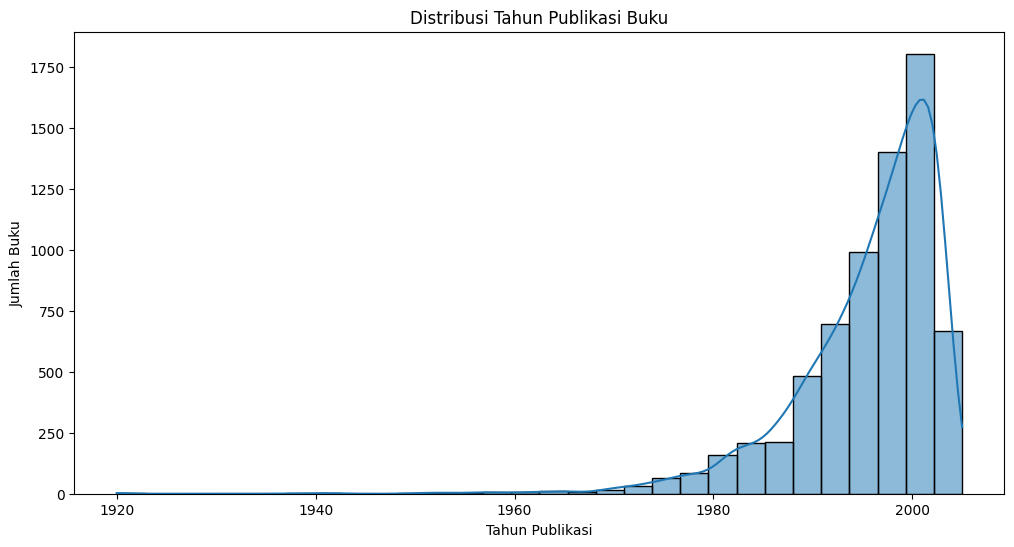

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mengubah tipe data 'Year-Of-Publication' menjadi numerik, menangani error
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

# Menghapus data dengan tahun publikasi yang tidak valid (misalnya, tahun > tahun saat ini)
current_year = pd.to_datetime('today').year
books_valid_year = books[(books['Year-Of-Publication'] > 0) & (books['Year-Of-Publication'] <= current_year)]

# Membuat plot distribusi tahun publikasi
plt.figure(figsize=(12, 6))
sns.histplot(books_valid_year['Year-Of-Publication'], bins=30, kde=True)
plt.title('Distribusi Tahun Publikasi Buku')
plt.xlabel('Tahun Publikasi')
plt.ylabel('Jumlah Buku')
plt.show()

Dapat dilihat bahwa rentang tahun publikasi buku paling banyak di tahun 2000an.

**Mengurangi entitas pada books variabel**

In [14]:
books = books[1:7001]
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 1 to 7000
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ISBN                 7000 non-null   object 
 1   Book-Title           7000 non-null   object 
 2   Book-Author          7000 non-null   object 
 3   Year-Of-Publication  7000 non-null   float64
 4   Publisher            7000 non-null   object 
 5   Image-URL-S          7000 non-null   object 
 6   Image-URL-M          7000 non-null   object 
 7   Image-URL-L          7000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 437.6+ KB


Dikarenakan terdapat lebih dari 200 ribu data, maka akan diambil 7000 data pertama dari `books` untuk digunakan dalam pembuatan model sistem rekomendasi.

**Melihat judul buku**

In [15]:
print("Banyak jumlah data :", len(books['Book-Title'].unique()))
print("Book Title         :", books['Book-Title'].unique())

Banyak jumlah data : 6750
Book Title         : ['Clara Callan' 'Decision in Normandy'
 'Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It'
 ... 'In a Dry Season' 'Cold Blood' 'Critical Mass']


*   Terdapat 6750 judul buku yang unik dalam dataset `books`.
*   Menampilkan beberapa judul buku unik. Menunjukkan keragaman judul buku yang ada dalam dataset. Hal ini mengindikasikan bahwa dataset ini mencakup berbagai macam buku.

### Users Variabel

**Informasi Dataset**

In [16]:
print("\nInformasi Dataset :")
users.info()


Informasi Dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


*   File users.csv memiliki 278858 entries.
*   Terdapat kolom `User-ID`, `Location`, dan `Age` pada dataset `users`

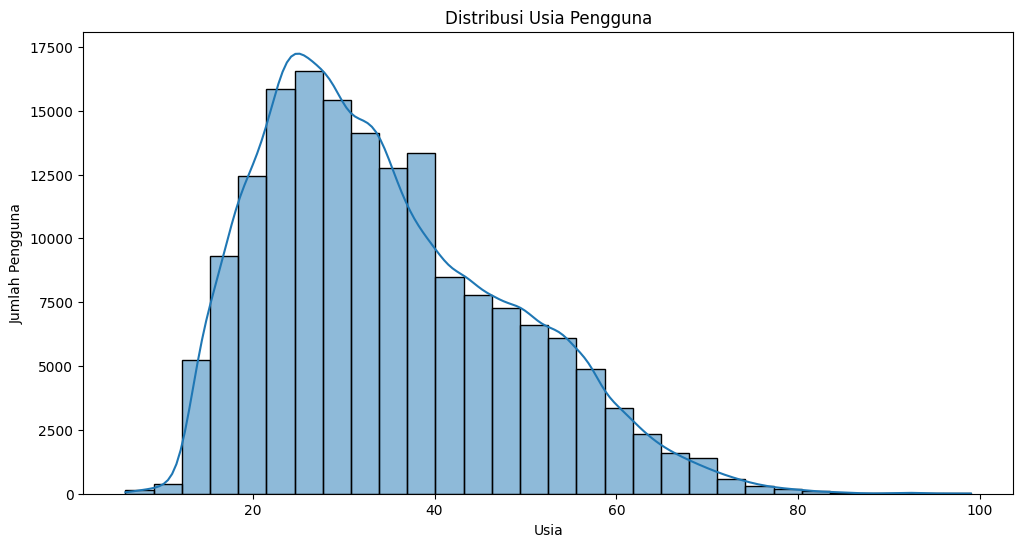

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

users['Age'] = pd.to_numeric(users['Age'], errors='coerce')

users_valid_age = users.dropna(subset=['Age'])

users_valid_age = users_valid_age[(users_valid_age['Age'] > 5) & (users_valid_age['Age'] < 100)]

# Membuat plot distribusi usia pengguna
plt.figure(figsize=(12, 6))
sns.histplot(users_valid_age['Age'], bins=30, kde=True)
plt.title('Distribusi Usia Pengguna')
plt.xlabel('Usia')
plt.ylabel('Jumlah Pengguna')
plt.show()

Banyak pengguna dalam rentang usia 20-an atau 30-an.

**Mengurangi entitas pada variabel users**

In [17]:
users = users[1:7001]
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 1 to 7000
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User-ID   7000 non-null   int64  
 1   Location  7000 non-null   object 
 2   Age       4368 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 164.2+ KB


Dikarenakan terdapat lebih dari 200 ribu data, maka akan diambil 7000 data pertama dari `users` untuk digunakan dalam pembuatan model sistem rekomendasi.

### Ratings Variabel

**Informasi Dataset**

In [19]:
print("\nInformasi Dataset :")
ratings.info()


Informasi Dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB



*   Kolom `User-ID` , `ISBN`, dan `Book-Rating` semuanya bertipe data integer (*int64*).
*   `User-ID` mengidentifikasi pengguna yang memberikan rating.
*   `ISBN` mengidentifikasi buku yang diberi rating.
*   `Book-Rating` menunjukkan rating yang diberikan oleh pengguna untuk buku-buku tertentu.
*   Tipe data integer untuk ketiga kolom sangat sesuai. `User-ID` dan `ISBN` merupakan ID unik, dan `Book-Rating` merupakan nilai numerik untuk rating.
*   Dataset `Ratings` berisi interaksi antara pengguna dan buku dalam bentuk rating. Dat ini menunjukkan preferensi pengguna terhadap buku-buku tertentu. Dataset ini merupakan yang terbesar, hal ini menunjukkan bahwa ada banyak interaksi rating yang tercatat.

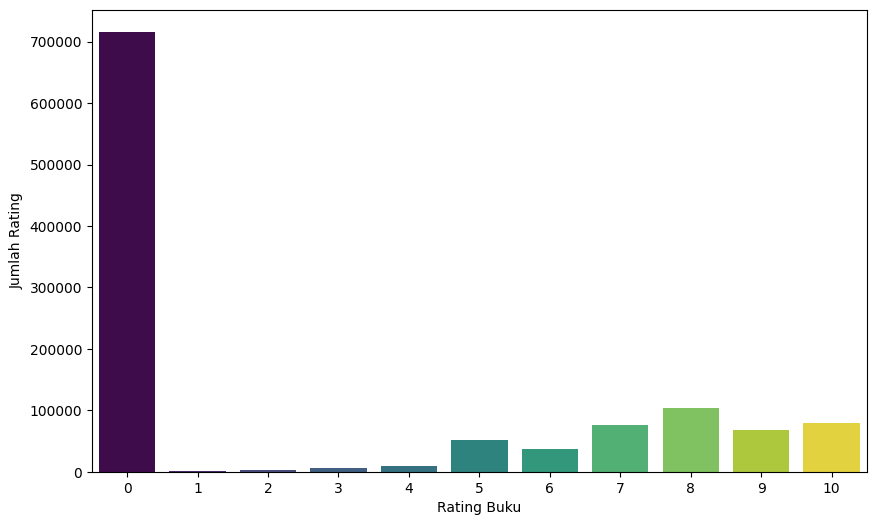

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ratings['Book-Rating'] = pd.to_numeric(ratings['Book-Rating'], errors='coerce')

ratings_clean = ratings.dropna(subset=['Book-Rating'])

# Membuat plot distribusi rating
plt.figure(figsize=(10, 6))
sns.countplot(x='Book-Rating', data=ratings, palette='viridis', hue='Book-Rating', legend=False)
plt.xlabel('Rating Buku')
plt.ylabel('Jumlah Rating')
plt.show()

Diagram diatas menunjukkan rating 0 atau rating rendah lebih condong, hal ini menunjukkan baik sejumlah besar buku yang tidak diberi rating, kecenderungan kuat pengguna untuk tidak menyukai buku atau ada kesalahan dalam mengimput data.

**Mengurangi entitas pada variabel ratings**

In [20]:
ratings = ratings[1:7001]
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 1 to 7000
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User-ID      7000 non-null   int64 
 1   ISBN         7000 non-null   object
 2   Book-Rating  7000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 164.2+ KB


Dikarenakan terdapat lebih dari 11 juta data, maka akan diambil 7000 data pertama dari `users` untuk digunakan dalam pembuatan model sistem rekomendasi.

In [21]:
ratings.describe()

,User-ID,Book-Rating
count,7000.000000,7000.000000
mean,277884.521857,2.120286
std,553.995650,3.514075
min,276726.000000,0.000000
25%,277427.000000,0.000000
50%,278074.500000,0.000000
75%,278418.000000,5.000000
max,278418.000000,10.000000


Untuk skala rating yaitu 0 - 10. Nilai minimal rating yaitu 0 dan nilai maksimumnya yaitu 10.

**Melihat jumlah pengguna memberikan rating, jumlah ISBN, serta jumlah data rating**

In [22]:
print("\nJumlah User-ID     :", len(ratings['User-ID'].unique()))
print("\nJumlah ISBN        :", len(ratings['ISBN'].unique()))
print("\nJumlah Data Rating :", len(ratings))


Jumlah User-ID     : 678

Jumlah ISBN        : 6600

Jumlah Data Rating : 7000


Dapat dilihat bahwa jumlah data pengguna yang memberikan rating sebanyak 678, jumlah buku sebanyak 6600 dan jumlah rating sebanyak 7000.

## Data Preprocessing

**Menghapus fitur yang tidak digunakan**

In [23]:
books = books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1)

In [24]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company
5,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group


**Mengecek missing value pada ratings**

In [25]:
print("\nJumlah missing value ratings : ")
ratings.isnull().sum()


Jumlah missing value ratings : 


,0
User-ID,0
ISBN,0
Book-Rating,0


Tidak terdapat missing value pada dataset `ratings`.

**Menghitung jumlah rating dan menggabungkan berdasarkan ISBN**

In [26]:
ratings.groupby('ISBN').sum()

,User-ID,Book-Rating
ISBN,,
0002231115,277962,0
0002232766,277962,0
0002240114,277996,6
000225669X,276912,6
000254794,277399,9
...,...,...
9995585227,277478,0
B0000BLD7X,276762,0
B158991965,276884,6


**Menggabungkan Ratings dengan Books**

In [27]:
ratings_all = ratings
ratings_all.head()

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0


Mendefinisikan variabel `ratings_all` dengan variabel `ratings` yang sudah ada sebelumnya.

In [28]:
books_all = pd.merge(ratings_all, books[['ISBN','Book-Title', 'Book-Author']], on='ISBN', how='left')
books_all.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author
0,276726,0155061224,5,NaN,NaN
1,276727,0446520802,0,NaN,NaN
2,276729,052165615X,3,NaN,NaN
3,276729,0521795028,6,NaN,NaN
4,276733,2080674722,0,NaN,NaN


*   Menggabungkan dataframe `ratings_all` dengan `books` dan memasukkan ke variabel `books_all`.
*   Karena dilakukan penggabungan fitur maka terdapat nilai yang hilang. Sehingga harus dilakukan pengecekan dan penangan missing value.

## Data Preparation

**Mengatasi missing value**

In [29]:
print("\nJumlah missing value books_all :")
books_all.isnull().sum()


Jumlah missing value books_all :


,0
User-ID,0
ISBN,0
Book-Rating,0
Book-Title,5971
Book-Author,5971


Terdapat missing values pada `Book-Title` dan `Book-Author` sebanyak 5971. Dan perlu dilakukan pembersihan data pada missing value.

In [30]:
print("\nJumlah Keseluruhan Buku :")
len(books_all)


Jumlah Keseluruhan Buku :


7000

In [31]:
books_all_clean = books_all.dropna()
books_all_clean.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0
Book-Title,0
Book-Author,0


Membersihkan missing value menggunakan fungsi `dropna()`. Dan kini sudah tidak ada missing value.

**Mengurutkan books berdasarkan nomor ISBN**

In [32]:
preparation = books_all_clean.sort_values('ISBN', ascending=True)
preparation.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author
4332,278418,0020418809,0,CADDIE WOODLAWN,Carol Ryrie Brink
4337,278418,0020442408,0,Prince Caspian,C. S. Lewis
4339,278418,0020532105,0,CRY THE BELOVED COUNTRY (Scribner Classic),Alan Paton
3988,278194,0020532105,10,CRY THE BELOVED COUNTRY (Scribner Classic),Alan Paton
1455,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner


**Mengatasi Data Duplikat**

In [33]:
preparation = preparation.drop_duplicates('ISBN')
preparation.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author
4332,278418,0020418809,0,CADDIE WOODLAWN,Carol Ryrie Brink
4337,278418,0020442408,0,Prince Caspian,C. S. Lewis
4339,278418,0020532105,0,CRY THE BELOVED COUNTRY (Scribner Classic),Alan Paton
1455,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1458,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",G. B. Trudeau


**Konversi data series menjadi list**

In [34]:
book_id = preparation['ISBN'].tolist()

book_title = preparation['Book-Title'].tolist()

book_author = preparation['Book-Author'].tolist()

print(len(book_id))
print(len(book_title))
print(len(book_author))

778
778
778


**Membuat dictionary baru untuk data Book ID, Book Title, Book Author**

In [35]:
new_book = pd.DataFrame({
    'id' : book_id,
    'book_title' : book_title,
    'book_author' : book_author
})

new_book.head()

,id,book_title,book_author
0,0020418809,CADDIE WOODLAWN,Carol Ryrie Brink
1,0020442408,Prince Caspian,C. S. Lewis
2,0020532105,CRY THE BELOVED COUNTRY (Scribner Classic),Alan Paton
3,002542730X,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
4,0030615321,"Ask for May, Settle for June (A Doonesbury book)",G. B. Trudeau


### Insight Data Preprocessing dan Preparation


*   Dataset yang besar (lebih dari 200 ribu entries untuk buku dan pengguna, serta jutaan rating) telah dikurangi menjadi 7000 data pertama untuk setiap dataset untuk kemudahan pemrosesan.
*   Fitur gambar seperti Image-URL-S, Image-URL-M, dan Img-URL-L yang tidak digunakan dalam model rekomendasi telah dihapus.
*   Missing values pada kolom Book-Title dan Book-Author setelah penggabungan dataset `Ratings` dan `Books` berhasil ditangani dengan menghapus baris yang mengandung missing values.
*   Data duplikat berdasarkan ISBN telah dihapus.
*   Data penting seperti ISBN, Book-Title dan Book-Author dikonversi menjadi list dan kemudian dibentuk menjadi DataFramw baru untuk persiapan model.







## Model Development dengan Content Based Filtering

**TF-IDF Vectorizer**

TF-IDF Vectorizer digunakan pada sistem rekomendasi untuk menemukan fitur yang penting dari setiap kategori buku.

In [36]:
tf = TfidfVectorizer()

tf.fit(new_book['book_title'])

tf.get_feature_names_out()

array(['00', '01', '101', ..., 'zweite', 'â¼fung', 'â¼gt'], dtype=object)

**Melakukan fit lalu ditransformasikan ke bentuk metrix**

In [37]:
tfidf_matrix = tf.fit_transform(new_book['book_title'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(778, 1541)

**Mengubah vektor tf-idf dalam bentuk metrix dengan fungsi todense**

In [38]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

**Membuat dataframe untuk melihat tf-idf matrix**

In [39]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=new_book.book_author
).sample(1541, axis=1).sample(10, axis=0)

,disaster,clay,similars,solstice,songcatcher,purity,off,mice,center,dude,...,remembered,charlotte,ashes,earthsea,fatal,brooklyn,ruth,news,hyde,syndrome
book_author,,,,,,,,,,,,,,,,,,,,,
Donna Woolfolk Cross,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
John Berendt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T. H. White,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
James Patterson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nicci French,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
William Shakespeare,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Carlo Lucarelli,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chrstine Lehmann,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
K. A. Applegate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Cosine Similarity**

In [40]:
cosine_similar = cosine_similarity(tfidf_matrix)
cosine_similar

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.18332102],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.18332102, 0.        ,
        1.        ]])

**Membuat dataframe dari variabel `cosine_similar` dengan baris dan kolom berupa book author**

In [41]:
df_cosine_similar = pd.DataFrame(
    cosine_similar,
    index=new_book['book_author'],
    columns=new_book['book_author']
)
print('Shape:', df_cosine_similar.shape)

df_cosine_similar.sample(7, axis=1).sample(10, axis=0)

Shape: (778, 778)


book_author,Ernst Ludwig Kirchner,James Patterson,Mary Higgins Clark,William Shakespeare,James Patterson,Mary Higgins Clark,Agatha Christie
book_author,,,,,,,
Lynne Reid Banks,0.093904,0.0,0.0,0.037377,0.0,0.0,0.099388
Marilyn French,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
Douglas Adams,0.026201,0.0,0.0,0.085814,0.0,0.0,0.079163
John Grisham,0.024915,0.0,0.0,0.028309,0.0,0.0,0.075276
Stephen King,0.000000,0.0,0.0,0.075934,0.0,0.0,0.000000
Stephen King,0.018491,0.0,0.0,0.021010,0.0,0.0,0.055866
Tom Clancy,0.023537,0.0,0.0,0.026744,0.0,0.0,0.133831
Amanda Quick,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
Judith Bowen,0.000000,0.0,0.0,0.042343,0.0,0.0,0.000000


**Mendapatkan Rekomendasi**

In [42]:
def book_recommendations(
    author_name,
    data_similarity=df_cosine_similar,
    items=new_book[['book_author', 'book_title']], n=10):

  index = data_similarity.loc[:, author_name].to_numpy().argpartition(
      range(-1, -n, -1)
  )

  closest = data_similarity.columns[index[-1:-(n+2):-1]]

  closest = closest.drop(author_name, errors='ignore')

  return pd.DataFrame(closest).merge(items).head(n)

In [43]:
new_book[new_book.book_author.eq('Peter Carey')]

,id,book_title,book_author
205,0375410848,True History of the Kelly Gang,Peter Carey


In [44]:
book_recommendations('Peter Carey')

,book_author,book_title
0,DONNA TARTT,Secret History
1,Jostein Gaarder,Sophie's World: A Novel About the History of P...
2,Sebastian Junger,The Perfect Storm: A True Story of Men Against...
3,Adeline Yen Mah,Falling Leaves: The True Story of an Unwanted ...
4,Wally Lamb,I Know This Much Is True
5,Wally Lamb,She's Come Undone (Oprah's Book Club (Paperback))
6,Wally Lamb,She's Come Undone (Oprah's Book Club)
7,Marc Levy,If Only It Were True
8,Stan Redding,Catch Me If You Can: The True Story of a Real ...
9,WILLIAM GOLDMAN,The Princess Bride: S Morgenstern's Classic Ta...


In [45]:
from sklearn.model_selection import train_test_split # Import untuk membagi data

# Gunakan DataFrame preparation yang sudah bersih dan unik berdasarkan ISBN
preparation = books_all_clean.sort_values('ISBN', ascending=True)
preparation = preparation.drop_duplicates('ISBN')

# Gunakan books_all_clean karena berisi User-ID, ISBN, dan rating
interaction_data = books_all_clean[['User-ID', 'ISBN', 'Book-Rating', 'Book-Title', 'Book-Author']]

train_interaction, test_interaction = train_test_split(
    interaction_data,
    test_size=0.2, # 20% untuk pengujian
    random_state=42
)

print(f"Jumlah data interaksi pelatihan: {len(train_interaction)}")
print(f"Jumlah data interaksi pengujian: {len(test_interaction)}")

# --- Bangun Model Content-Based Filtering dari Data Pelatihan ---

# Ambil buku-buku unik dari data interaksi pelatihan untuk membangun model
train_books = train_interaction.drop_duplicates('ISBN')[['ISBN', 'Book-Title', 'Book-Author']]
train_books = train_books.reset_index(drop=True) # Reset index

print(f"\nJumlah buku unik dalam data pelatihan: {len(train_books)}")

# TF-IDF Vectorizer pada judul buku dari data pelatihan
tf_eval = TfidfVectorizer()
tfidf_matrix_eval = tf_eval.fit_transform(train_books['Book-Title'].fillna('')) # Isi NaN dengan string kosong

# Cosine Similarity dari matriks TF-IDF pelatihan
cosine_sim_eval = cosine_similarity(tfidf_matrix_eval)

# Petakan ISBN buku pelatihan ke indeks dalam matriks kemiripan
isbn_to_index_eval = {isbn: i for i, isbn in enumerate(train_books['ISBN'])}
index_to_isbn_eval = {i: isbn for i, isbn in enumerate(train_books['ISBN'])}

# --- Fungsi Rekomendasi yang Menggunakan Model Pelatihan ---

def get_content_based_recommendations_eval(user_id, k=10):
    """
    Memberikan rekomendasi Content-Based untuk pengguna berdasarkan buku yang disukai
    di set pelatihan dan kemiripan konten dari model pelatihan.
    """
    # Dapatkan buku yang disukai pengguna di set pelatihan
    user_liked_books_train = train_interaction[(train_interaction['User-ID'] == user_id) & (train_interaction['Book-Rating'] >= 7)] # Asumsi rating >= 7 berarti disukai

    if user_liked_books_train.empty:
        return [] # Tidak ada buku yang disukai di pelatihan, tidak bisa merekomendasikan

    # Ambil ISBN dari buku yang disukai
    liked_book_isbns = user_liked_books_train['ISBN'].tolist()

    # Cari indeks buku yang disukai dalam matriks kemiripan pelatihan
    liked_book_indices = [isbn_to_index_eval[isbn] for isbn in liked_book_isbns if isbn in isbn_to_index_eval]

    if not liked_book_indices:
        return [] # Buku yang disukai tidak ada di set buku pelatihan

    # Hitung skor kemiripan rata-rata dengan semua buku lain
    # Berdasarkan buku-buku yang disukai pengguna
    similarity_scores = np.mean(cosine_sim_eval[liked_book_indices], axis=0)

    # Urutkan buku berdasarkan skor kemiripan (dari tertinggi ke terendah)
    sorted_indices = np.argsort(similarity_scores)[::-1]

    # Dapatkan ISBN buku yang direkomendasikan (selain buku yang sudah disukai pengguna)
    recommended_book_isbns = []
    for index in sorted_indices:
        isbn = index_to_isbn_eval[index]
        # Pastikan buku belum disukai pengguna di set pelatihan
        if isbn not in liked_book_isbns:
            recommended_book_isbns.append(isbn)
            if len(recommended_book_isbns) == k:
                break

    return recommended_book_isbns

# --- Hitung Metrik Evaluasi (Precision@k dan Recall@k) ---

k = 10 # Jumlah rekomendasi (top-k)
total_precision = 0
total_recall = 0
num_users_evaluated = 0

# Evaluasi untuk setiap pengguna dalam set pengujian yang memiliki buku disukai di set pelatihan
users_in_test = test_interaction['User-ID'].unique()

for user_id in users_in_test:
    # Dapatkan buku yang sebenarnya disukai pengguna di set pengujian
    actual_liked_books_test = test_interaction[(test_interaction['User-ID'] == user_id) & (test_interaction['Book-Rating'] >= 7)] # Asumsi rating >= 7 berarti disukai
    actual_liked_book_isbns = actual_liked_books_test['ISBN'].tolist()

    if not actual_liked_book_isbns:
        continue # Pengguna tidak menyukai buku apapun di set pengujian, lewati

    # Dapatkan rekomendasi Content-Based untuk pengguna ini
    recommended_book_isbns = get_content_based_recommendations_eval(user_id, k=k)

    if not recommended_book_isbns:
        continue # Tidak dapat memberikan rekomendasi untuk pengguna ini, lewati

    # Hitung jumlah item yang relevan (item yang disukai pengguna di set pengujian)
    num_relevant_items = len(actual_liked_book_isbns)

    # Hitung jumlah item yang direkomendasikan yang relevan (intersection)
    relevant_recommended_items = len(set(recommended_book_isbns).intersection(set(actual_liked_book_isbns)))

    # Hitung Precision@k dan Recall@k untuk pengguna ini
    precision_at_k = relevant_recommended_items / k if k > 0 else 0
    recall_at_k = relevant_recommended_items / num_relevant_items if num_relevant_items > 0 else 0

    total_precision += precision_at_k
    total_recall += recall_at_k
    num_users_evaluated += 1

# Hitung rata-rata Precision@k dan Recall@k di seluruh pengguna
average_precision_at_k = total_precision / num_users_evaluated if num_users_evaluated > 0 else 0
average_recall_at_k = total_recall / num_users_evaluated if num_users_evaluated > 0 else 0

print(f"\n--- Metrik Evaluasi Content-Based Filtering (k={k}) ---")
print(f"Jumlah pengguna yang dievaluasi: {num_users_evaluated}")
print(f"Average Precision@{k}: {average_precision_at_k:.4f}")
print(f"Average Recall@{k}: {average_recall_at_k:.4f}")

Jumlah data interaksi pelatihan: 823
Jumlah data interaksi pengujian: 206

Jumlah buku unik dalam data pelatihan: 649

--- Metrik Evaluasi Content-Based Filtering (k=10) ---
Jumlah pengguna yang dievaluasi: 27
Average Precision@10: 0.0074
Average Recall@10: 0.0556


Model Content-Based Filtering mencapai Average Precision@10 sebesar 0.0074 dan Average Recall@10 sebesar 0.0556 pada set pengujian. Ini menunjukkan bahwa rata-rata, 0.74% dari 10 rekomendasi teratas relevan bagi pengguna, dan model berhasil menangkap sekitar 5.56% dari total buku yang disukai pengguna dalam 10 rekomendasi teratas.

### Insight


*   Model Content Based Filtering dibangun menggunakan Book-Title sebagai fitur.
*   TfidfVectorizer digunakan untuk mengekstrak fitur penting dari judul buku dan mengubahnya menjadi representasi numerik dalam bentuk matriks TF-IDF.
*   Cosine Similarity dihitung berdasarkan matriks TF-IDF untuk mengukur kemiripan antar buku berdasarkan judulnya.
*   Fungsi book_recommendations dibuat untuk memberikan rekomendasi buku berdasarkan nama penulis, dengan mencari buku-buku yang memiliki kemiripan judul tertinggi.

## Evaluasi

### Model Development dengan Collaborative Filtering

**Import Library**

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

### Data Understanding

In [47]:
data = ratings
data.head()

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0


### Data Preparation

**Mengubah `User-ID` menjadi list**

In [48]:
users_id = data['User-ID'].unique().tolist()
print('list User-ID: ', users_id)

list User-ID:  [276726, 276727, 276729, 276733, 276736, 276737, 276744, 276745, 276746, 276747, 276748, 276751, 276754, 276755, 276760, 276762, 276765, 276768, 276772, 276774, 276780, 276786, 276788, 276796, 276798, 276800, 276803, 276804, 276806, 276808, 276811, 276812, 276813, 276814, 276817, 276820, 276822, 276827, 276828, 276830, 276832, 276833, 276835, 276837, 276838, 276840, 276842, 276847, 276848, 276850, 276852, 276853, 276854, 276856, 276857, 276859, 276861, 276862, 276863, 276866, 276869, 276870, 276872, 276873, 276875, 276878, 276879, 276884, 276887, 276888, 276889, 276890, 276896, 276904, 276905, 276911, 276912, 276915, 276916, 276925, 276927, 276928, 276929, 276934, 276936, 276939, 276943, 276946, 276949, 276950, 276953, 276954, 276957, 276959, 276963, 276964, 276965, 276975, 276981, 276984, 276986, 276988, 276989, 276990, 276992, 276994, 276997, 276998, 277002, 277007, 277009, 277010, 277012, 277018, 277019, 277022, 277023, 277028, 277031, 277032, 277035, 277036, 277040, 

**Melakukan encoding `User-ID`**

In [49]:
users_encoded = {x: i for i, x in enumerate(users_id)}
print('Encoding User-ID :',users_encoded)

Encoding User-ID : {276726: 0, 276727: 1, 276729: 2, 276733: 3, 276736: 4, 276737: 5, 276744: 6, 276745: 7, 276746: 8, 276747: 9, 276748: 10, 276751: 11, 276754: 12, 276755: 13, 276760: 14, 276762: 15, 276765: 16, 276768: 17, 276772: 18, 276774: 19, 276780: 20, 276786: 21, 276788: 22, 276796: 23, 276798: 24, 276800: 25, 276803: 26, 276804: 27, 276806: 28, 276808: 29, 276811: 30, 276812: 31, 276813: 32, 276814: 33, 276817: 34, 276820: 35, 276822: 36, 276827: 37, 276828: 38, 276830: 39, 276832: 40, 276833: 41, 276835: 42, 276837: 43, 276838: 44, 276840: 45, 276842: 46, 276847: 47, 276848: 48, 276850: 49, 276852: 50, 276853: 51, 276854: 52, 276856: 53, 276857: 54, 276859: 55, 276861: 56, 276862: 57, 276863: 58, 276866: 59, 276869: 60, 276870: 61, 276872: 62, 276873: 63, 276875: 64, 276878: 65, 276879: 66, 276884: 67, 276887: 68, 276888: 69, 276889: 70, 276890: 71, 276896: 72, 276904: 73, 276905: 74, 276911: 75, 276912: 76, 276915: 77, 276916: 78, 276925: 79, 276927: 80, 276928: 81, 276929

**Melakukan encoding angka ke `User-ID`**

In [50]:
users_encoded_to_user = {i: x for i, x in enumerate(users_id)}
print('Encoding angka ke User-ID :', users_encoded_to_user)

Encoding angka ke User-ID : {0: 276726, 1: 276727, 2: 276729, 3: 276733, 4: 276736, 5: 276737, 6: 276744, 7: 276745, 8: 276746, 9: 276747, 10: 276748, 11: 276751, 12: 276754, 13: 276755, 14: 276760, 15: 276762, 16: 276765, 17: 276768, 18: 276772, 19: 276774, 20: 276780, 21: 276786, 22: 276788, 23: 276796, 24: 276798, 25: 276800, 26: 276803, 27: 276804, 28: 276806, 29: 276808, 30: 276811, 31: 276812, 32: 276813, 33: 276814, 34: 276817, 35: 276820, 36: 276822, 37: 276827, 38: 276828, 39: 276830, 40: 276832, 41: 276833, 42: 276835, 43: 276837, 44: 276838, 45: 276840, 46: 276842, 47: 276847, 48: 276848, 49: 276850, 50: 276852, 51: 276853, 52: 276854, 53: 276856, 54: 276857, 55: 276859, 56: 276861, 57: 276862, 58: 276863, 59: 276866, 60: 276869, 61: 276870, 62: 276872, 63: 276873, 64: 276875, 65: 276878, 66: 276879, 67: 276884, 68: 276887, 69: 276888, 70: 276889, 71: 276890, 72: 276896, 73: 276904, 74: 276905, 75: 276911, 76: 276912, 77: 276915, 78: 276916, 79: 276925, 80: 276927, 81: 27692

In [51]:
books_id = data['ISBN'].unique().tolist()

books_to_book_encoded = {x: i for i, x in enumerate(books_id)}

books_encoded_to_book = {i: x for i, x in enumerate(books_id)}

# Menggunakan .loc untuk menghindari SettingWithCopyWarning
data.loc[:, 'user'] = data['User-ID'].map(users_encoded)
data.loc[:, 'book'] = data['ISBN'].map(books_to_book_encoded)

In [52]:
# Mendapatkan jumlah user
num_users = len(users_encoded)
print(num_users)

# Mendapatkan jumlah buku
num_book = len(books_encoded_to_book)
print(num_book)

# Mengubah rating menjadi nilai float
data.loc[:, 'Book-Rating'] = data['Book-Rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(data['Book-Rating'])

# Nilai maksimal rating
max_rating = max(data['Book-Rating'])

print('Number of User: {}, Number of Book: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_book, min_rating, max_rating
))

678
6600
Number of User: 678, Number of Book: 6600, Min Rating: 0, Max Rating: 10


**Membagi data untuk Training dan Validasi**

In [53]:
data = data.sample(frac=1, random_state=42)

data.head()

,User-ID,ISBN,Book-Rating,user,book
6501,278418,0446364304,0,677,6123
2945,277879,0380710056,6,453,2800
2025,277478,0146000552,0,272,1961
264,276856,2800135719,0,53,262
4351,278418,003021436X,0,677,4051


In [54]:
X = data[['user', 'book']].values

y = data['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * data.shape[0])
X_train, X_val, y_train, y_val = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [55]:
print(X, y)

[[ 677 6123]
 [ 453 2800]
 [ 272 1961]
 ...
 [ 677 4904]
 [ 677 5066]
 [ 138  850]] [0.  0.6 0.  ... 0.  0.  0.8]


**Proses Training**

In [56]:
class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_book, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_book = num_book
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.book_embedding = layers.Embedding(
        num_book,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.book_bias = layers.Embedding(num_book, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    book_vector = self.book_embedding(inputs[:, 1]) # memanggil layer embedding 3
    book_bias = self.book_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_book = tf.tensordot(user_vector, book_vector, 2)

    X = dot_user_book + user_bias + book_bias # Variable X is defined here

    return tf.nn.sigmoid(X) # Corrected: using X instead of x

In [57]:
model = RecommenderNet(num_users, num_book, 50)
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [58]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (X_val, y_val)
)

Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.6378 - root_mean_squared_error: 0.4213 - val_loss: 0.5288 - val_root_mean_squared_error: 0.3603
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.4559 - root_mean_squared_error: 0.3189 - val_loss: 0.4882 - val_root_mean_squared_error: 0.3387
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.4215 - root_mean_squared_error: 0.3024 - val_loss: 0.4634 - val_root_mean_squared_error: 0.3271
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.3898 - root_mean_squared_error: 0.2848 - val_loss: 0.4449 - val_root_mean_squared_error: 0.3190
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.3776 - root_mean_squared_error: 0.2768 - val_loss: 0.4319 - val_root_mean_squared_error: 0.3135
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.3638 - root_mean_squared_error: 0.2677 - val_loss: 0.4237 - val_root_mean_squared_error: 0.3099
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 8

In [59]:
df_books = new_book
df = pd.read_csv('/content/book_recommendation/Ratings.csv')
data = df[1:7001]

user_id = data['User-ID'].sample(100).iloc[30]

book_visited_by_user = data[data['User-ID'] == user_id]

book_not_visited = df_books[~df_books['id'].isin(book_visited_by_user.ISBN.values)]['id']
book_not_visited = list(
    set(book_not_visited)
    .intersection(set(books_to_book_encoded.keys()))
)

book_not_visited = [[books_to_book_encoded.get(x)] for x in book_not_visited]
user_encoder = users_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_visited), book_not_visited)
)

In [60]:
rating = model.predict(user_book_array).flatten()

top_rating_indices = rating.argsort()[-10:][::-1]
recommended_book_ids = [
    books_encoded_to_book.get(book_not_visited[x][0]) for x in top_rating_indices
]

top_book_user = (
    book_visited_by_user.sort_values(
        by = 'Book-Rating',
        ascending=False
    )
    .head(5)
    .ISBN.values
)

df_books_rows = df_books[df_books['id'].isin(top_book_user)]
for row in df_books_rows.itertuples():
    print(row.book_author, ':', row.book_title)

print('---' * 11)
print('10 Rekomendasi Teratas berdasarkan Book Author')
print('---' * 11)

recommended_book = df_books[df_books['id'].isin(recommended_book_ids)]
for row in recommended_book.itertuples():
    print(row.book_author, ':', row.book_title)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
---------------------------------
10 Rekomendasi Teratas berdasarkan Book Author
---------------------------------
J R R Tolkien : The Hobbit
Iain Banks : The Wasp Factory
Dean R. Koontz : Hideaway
CHRISTOPHER PAUL CURTIS : The Watsons Go to Birmingham - 1963 (Yearling Newbery)
Nelson DeMille : The Lion's Game
Leslie Dunkling : The New American Dictionary of Baby Names
Ann M. Martin : Good-Bye Stacey, Good-Bye (Baby-Sitters Club (Paperback))
Pearl S. Buck : The Good Earth (Enriched Classics)
Jack Canfield : Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series (Paper))
Carlos Ruiz Zafon : La Sombra del Viento


### Insight

*   Model Collaborative Filtering dibangun menggunakan dataset Ratings.
User-ID dan ISBN di-encode menjadi representasi numerik untuk dapat diproses oleh model machine learning.
*   Rentang rating dinormalisasi antara 0 dan 1.
Data dibagi menjadi set pelatihan dan validasi (80:20).
*   Model RecommenderNet berbasis embedding dikembangkan menggunakan TensorFlow/Keras.
*   Model ini mempelajari representasi (embedding) untuk setiap pengguna dan buku, serta bias masing-masing. Rekomendasi dihasilkan dari perkalian dot antara embedding pengguna dan buku, ditambah bias.
*   Model dilatih menggunakan Binary Crossentropy sebagai fungsi loss dan Adam optimizer.

**Evaluasi**

**1. Metrik Root Mean Squared Error (RMSE)**

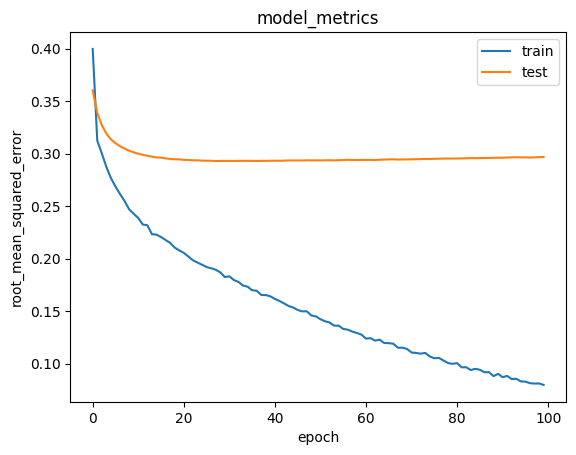

In [61]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

**2. Mean Squared Error (MSE)**

In [62]:
from sklearn.metrics import mean_squared_error

print("MSE dari pada data train = ", mean_squared_error(y_true=y_train, y_pred=model.predict(X_train)))
print("MSE dari pada data validation = ", mean_squared_error(y_true=y_val, y_pred=model.predict(X_val)))

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE dari pada data train =  0.029270251753493248
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MSE dari pada data validation =  0.08808465074007817


### Insight

*   Kinerja model Collaborative Filtering dievaluasi menggunakan metrik Root Mean Squared Error (RMSE) dan Mean Squared Error (MSE).
*   Plot dari RMSE pada set pelatihan dan validasi selama pelatihan ditampilkan untuk memantau konvergensi model.
*   Nilai MSE dihitung untuk data pelatihan dan validasi, memberikan indikasi seberapa dekat prediksi model dengan nilai rating sebenarnya.